# Loan Prediction 03 - Training and Validation of models with manual data imputation

We propose models of two different natures (regression based and tree based) to execute the credit analysis for the loan approval.

- Logitic Regression
- Ridge Regression
- Random Forest
- Extreme Gradient Boosting


Since we only have the classes for the train_dataset, we will consider it as the entire data set. Hence, 20% of this data will be kept separate for final performance comparison.

We will apply a GridSearch along with a Cross Validation of 10 folds to find each models best hyper parameters.

For this type of problem, let us assume that the F1-Score is a good evaluation metric, since maximizing it can offer a good spot between the approved and rejected loans.

That is, we want to have a good balance of false negatives (reject loans that should be approved) and false positives (approved loans that should be rejected). 

Finally, we can say that the bank will take risks, approving improper transactions aiming to maximize their profit.

In [15]:
import math
import sys
from joblib import dump, load
sys.path.append('utils')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import metrics_utils 
import model_utils

In [24]:
df_import = pd.read_csv('dataset/train_loan_preprocessed.csv')
print(df_import.shape)
score = 'accuracy'

(491, 14)


In [25]:
columns_x = df_import.drop(columns=['Loan_Status']).columns
column_y = ['Loan_Status']

X_train, X_validation, y_train, y_validation = train_test_split(
    df_import[columns_x], df_import[column_y],  test_size=0.20, random_state=42)

In [26]:
scaler = MinMaxScaler()
scaler.fit(df_import[columns_x])
dump(scaler, 'saves/minmax_scaler_manual_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

In [27]:
display(X_train_norm.describe())
print(X_train_norm.shape)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Base_Loan_Installment,Remaining_Income
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,0.816327,0.650510,0.265306,0.219388,0.130102,0.253158,0.152486,0.335566,0.626701,0.864796,0.521684,0.244011,0.720834
std,0.387713,0.477418,0.343690,0.414361,0.336846,0.165164,0.177773,0.155528,0.160690,0.342378,0.395194,0.124863,0.122087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.151568,0.000000,0.245283,0.666667,1.000000,0.000000,0.165756,0.674797
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.199833,0.132350,0.311321,0.666667,1.000000,0.500000,0.217668,0.730342
75%,1.000000,1.000000,0.666667,0.000000,0.000000,0.299251,0.250640,0.407008,0.666667,1.000000,1.000000,0.297359,0.788672
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.949931,0.902673,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(392, 13)


In [28]:
display(X_validation_norm.describe())
print(X_validation_norm.shape)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Base_Loan_Installment,Remaining_Income
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.797980,0.585859,0.178451,0.212121,0.101010,0.243335,0.167506,0.348961,0.636364,0.787879,0.459596,0.253338,0.715653
std,0.403551,0.495080,0.298572,0.410891,0.302876,0.154598,0.199347,0.159564,0.126804,0.410891,0.382505,0.133491,0.099381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.003331,0.000000,0.105121,0.166667,0.000000,0.000000,0.071038,0.264518
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.145740,0.000000,0.253369,0.666667,1.000000,0.000000,0.171220,0.671901
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.201221,0.144989,0.315364,0.666667,1.000000,0.500000,0.216758,0.722706
75%,1.000000,1.000000,0.333333,0.000000,0.000000,0.302387,0.242483,0.407008,0.666667,1.000000,0.750000,0.297814,0.768307
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.989218,1.000000,1.000000,1.000000,0.668488,0.951500


(99, 13)


### Logistic Regression Classifier

In [31]:
logistic_regression_params = {
    'C' : [1,2,5,10,50,100,1000],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

best_lr,best_lr_params,best_lr_score = model_utils.find_best_classification_model_with_cross_validation(
    LogisticRegression(random_state=0, class_weight = 'balanced'),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = score)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


--- Ellapsed time: 2.102095365524292 seconds ---
Best params:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score (accuracy) 0.7960897435897436


[Parallel(n_jobs=-1)]: Done 1313 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    2.1s finished


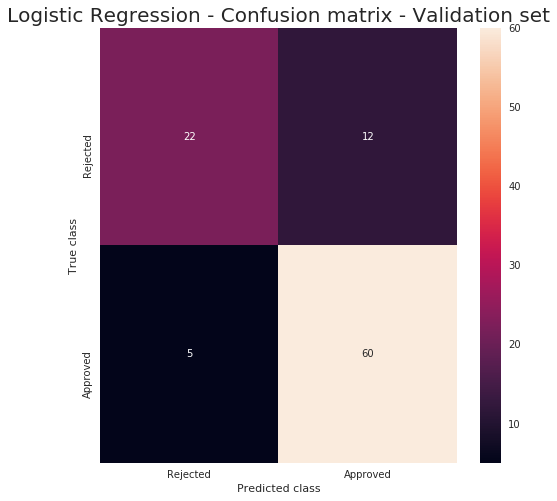

              precision    recall  f1-score   support

    Rejected       0.81      0.65      0.72        34
    Approved       0.83      0.92      0.88        65

    accuracy                           0.83        99
   macro avg       0.82      0.79      0.80        99
weighted avg       0.83      0.83      0.82        99

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.835


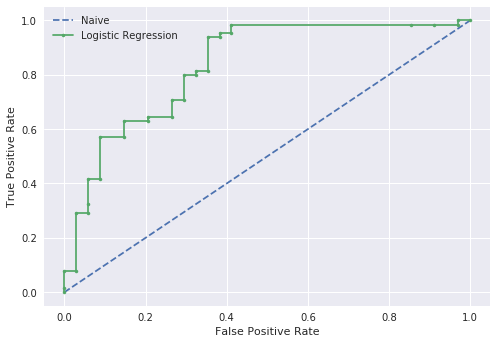

['saves/logistic_regression_manual_imputation.bin']

In [32]:
df_result = model_utils.predict(best_lr,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_validation_norm,y_validation,df_result)
dump(best_lr, 'saves/logistic_regression_manual_imputation.bin', compress=True)

### Ridge Regressor Classification

In [33]:
ridge_regression_params = {
    'alpha' : [1,10,100,1000],
    'solver' : ['auto', 'svd', 'lsqr', 'sag', 'cholesky','saga','sparse_cg']
}

best_ridge,best_ridge_params,best_ridge_score = model_utils.find_best_classification_model_with_cross_validation(
    RidgeClassifier(random_state=0, class_weight = 'balanced'),
    ridge_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = score)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


--- Ellapsed time: 0.4152488708496094 seconds ---
Best params:  {'alpha': 1, 'solver': 'auto'}
Best score (accuracy) 0.7883974358974359


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.4s finished


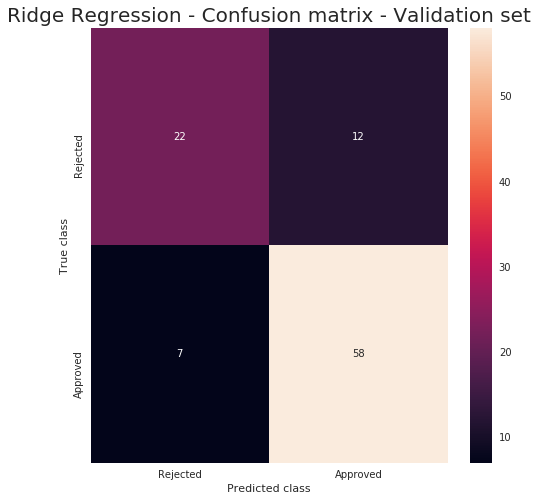

              precision    recall  f1-score   support

    Rejected       0.76      0.65      0.70        34
    Approved       0.83      0.89      0.86        65

    accuracy                           0.81        99
   macro avg       0.79      0.77      0.78        99
weighted avg       0.80      0.81      0.80        99

Could not print ROC AUC curve.


['saves/ridge_regression_manual_imputation.bin']

In [34]:
df_result = model_utils.predict(best_ridge,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_ridge, 'Ridge Regression',X_validation_norm,y_validation,df_result)
dump(best_ridge, 'saves/ridge_regression_manual_imputation.bin', compress=True)

### Random Forest Classifier

In [35]:
random_forest_params = {
    'n_estimators' : [50,100,150,200],
    'min_samples_split': [2,3,4,5],
    'max_depth':[5,8,10,13,15],
    'criterion':['gini','entropy'],
    'oob_score':[True]
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_utils.find_best_classification_model_with_cross_validation(
    RandomForestClassifier(random_state=0, class_weight = 'balanced'),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = score)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min


--- Ellapsed time: 94.01862597465515 seconds ---
Best params:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}
Best score (accuracy) 0.8316666666666667


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.6min finished


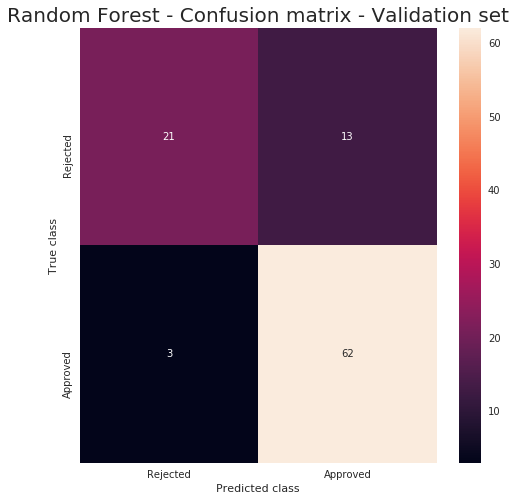

              precision    recall  f1-score   support

    Rejected       0.88      0.62      0.72        34
    Approved       0.83      0.95      0.89        65

    accuracy                           0.84        99
   macro avg       0.85      0.79      0.80        99
weighted avg       0.84      0.84      0.83        99

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.838


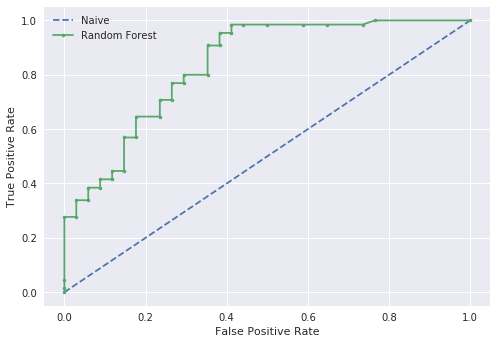

['saves/random_forest_manual_imputation.bin']

In [36]:
df_result = model_utils.predict(best_random_forest,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_random_forest, model_name = 'Random Forest', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_random_forest, 'saves/random_forest_manual_imputation.bin', compress=True)

### Gradient Boosting

In [37]:
gboost_params = {
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.01,0.1],
    'n_estimators' : [50,100,150],
    'min_samples_split': [2,3,4,5],
    'max_depth':[2,3,5,8]
}

best_gboost,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    GradientBoostingClassifier(random_state=0),
    gboost_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = score)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   52.3s


--- Ellapsed time: 72.27583837509155 seconds ---
Best params:  {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score (accuracy) 0.8241025641025642


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.2min finished


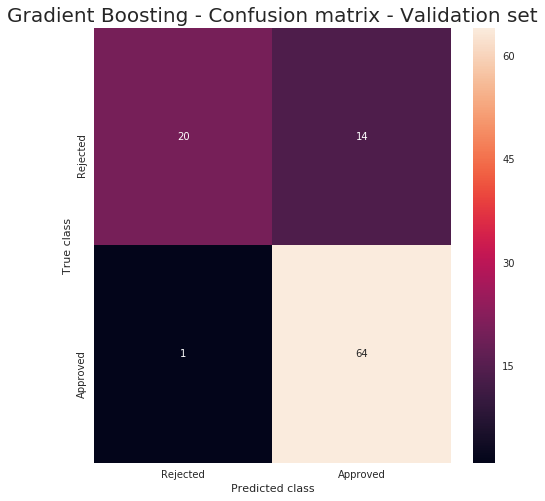

              precision    recall  f1-score   support

    Rejected       0.95      0.59      0.73        34
    Approved       0.82      0.98      0.90        65

    accuracy                           0.85        99
   macro avg       0.89      0.79      0.81        99
weighted avg       0.87      0.85      0.84        99

No Skill: ROC AUC=0.500
Gradient Boosting : ROC AUC=0.846


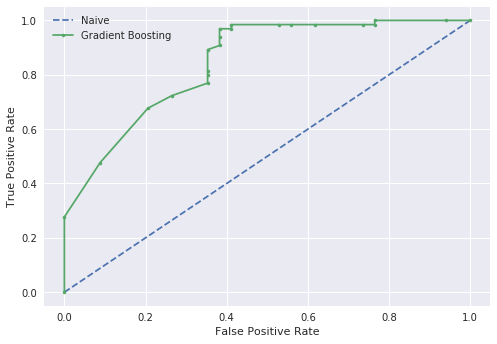

['saves/gradient_boosting_manual_imputation.bin']

In [38]:
df_result = model_utils.predict(best_gboost,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/gradient_boosting_manual_imputation.bin', compress=True)

### Extreme Gradient Boosting

In [39]:
xgb_params = {'objective':['binary:logistic'],
              'learning_rate': [0.1,0.3,0.5],
              'gamma':[0,1],
              'max_depth': [3,4,6,10],
              'subsample': [0.5, 1],
              'n_estimators': [50,100,150],
              'missing':[-999]}

best_xgb,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    XGBClassifier(seed=0),
    xgb_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = score)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.8s


--- Ellapsed time: 15.470055103302002 seconds ---
Best params:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'missing': -999, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 1}
Best score (accuracy) 0.8216666666666665


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.4s finished


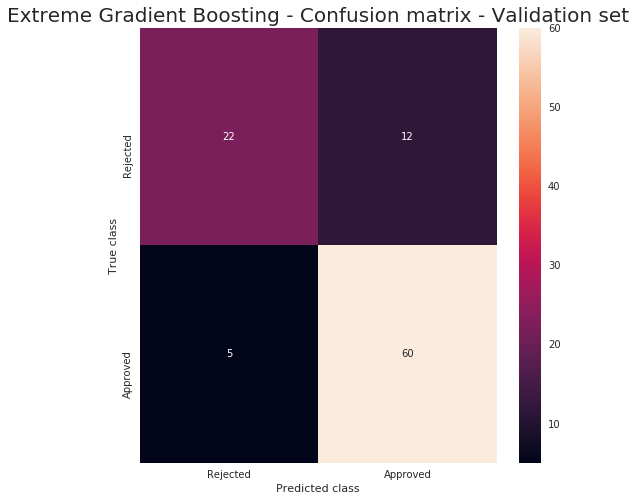

              precision    recall  f1-score   support

    Rejected       0.81      0.65      0.72        34
    Approved       0.83      0.92      0.88        65

    accuracy                           0.83        99
   macro avg       0.82      0.79      0.80        99
weighted avg       0.83      0.83      0.82        99

No Skill: ROC AUC=0.500
Extreme Gradient Boosting : ROC AUC=0.846


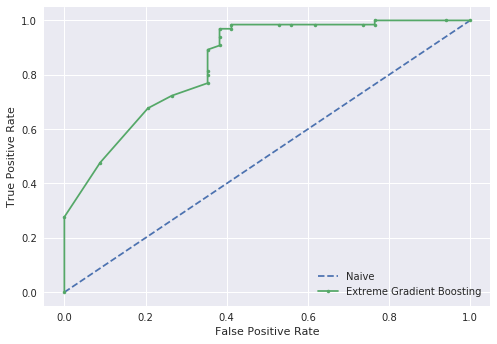

['saves/extreme_gradient_boosting_manual_imputation.bin']

In [40]:
df_result = model_utils.predict(best_xgb,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Extreme Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/extreme_gradient_boosting_manual_imputation.bin', compress=True)

### Conclusion

Since the Ridge Regression is capable to execute some feature selection and had the same performance as the Logistic Regression, we can assume that all variables must be important to this problem and that the correlation between the Loan Amount and the Loan Installment is not a problem.

However, the tree based models showed better performance both durtion cross validation and the "final" validation, preseting better F1-Score and Accuracy.

Let us see (in the next notebooks) how these models will perform when the missing data is filled by a Random Forest algorithm.